In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "12345@54321",
                             database = "ecommerce2")

cur = db.cursor()

 **1.list all unique cities where all he customers are located**

In [3]:
query_1 = """ select distinct(customer_city) from customers"""

cur.execute(query_1)

data_1 = cur.fetchall()

df  = pd.DataFrame(data_1)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


**2.count the number of orders in the year of 2017**

In [4]:
query_2 = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query_2)

data_2 = cur.fetchall()

"total order placed in 2017 are:",data_2[0][0]


('total order placed in 2017 are:', 45101)

**3.find the total sales per category**

In [8]:
query_3 = """select  upper(products.product_category)  category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category 
"""

cur.execute(query_3)

data_3 = cur.fetchall()

df =pd.DataFrame(data_3,columns = ["category","sales"])

df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


**4.calculate  the percentage of orders that were paid in installments.**

In [10]:
query_4 = """select sum(case when payment_installments >= 1 then 1
else 0 end)/count(*)*100 from payments
"""

cur.execute(query_4)

data = cur.fetchall()

data

[(Decimal('99.9981'),)]

**5.count the number of customers from each state**

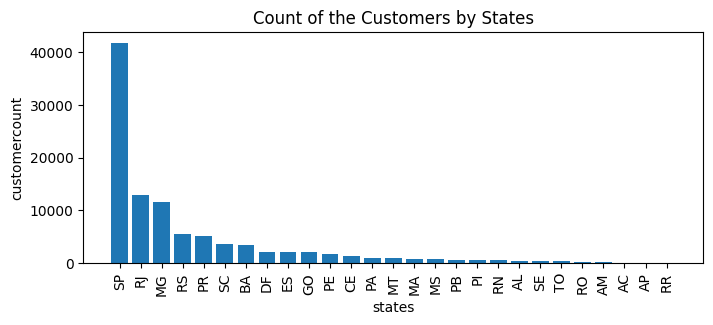

In [11]:
query_5 = """ select customer_state,count(customer_id)
from customers group by customer_state 
"""
cur.execute(query_5)

data = cur.fetchall()

df = pd.DataFrame(data, columns =["state","customercount"])
df = df.sort_values(by = "customercount",ascending = False)
df

plt.figure(figsize = (8,3))
plt.bar(df["state"],df["customercount"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customercount")
plt.title("Count of the Customers by States")
plt.show()

##INTERMEDIATE QUERIES

**6.calculate the number of orders permonth in 2018**

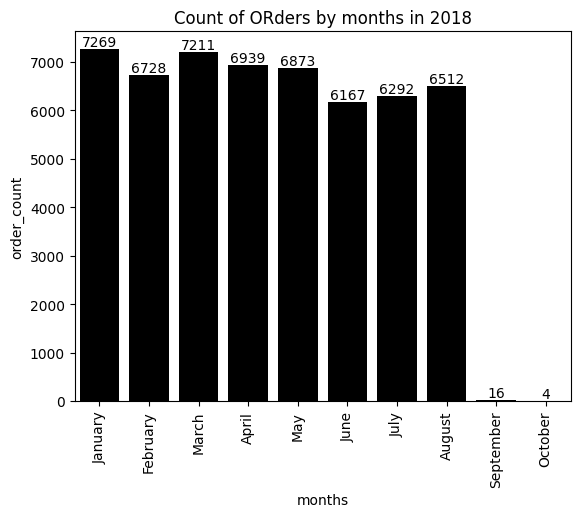

In [12]:
query_6 = """ select monthname(order_purchase_timestamp)  months,count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query_6)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["months","order_count"])
o = ["January","February","March","April","May","June","July","August","September","October"]


ax = sns.barplot(x = df["months"], y =df["order_count"],data = df , order = o ,color = "black")
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title("Count of ORders by months in 2018")
plt.show()

**7.find the average number of products per order,grouped by customer city**

In [13]:
query = """ with count_per_order as (select orders.order_id,orders.customer_id,count(order_items.order_id) as oc 
from  orders join order_items
on orders.order_id = order_items.order_id
group by  orders.order_id,orders.customer_id)

select upper(customers.customer_city), round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city  order by  average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df =pd.DataFrame(data,columns = ["customer_city","average products/order"])
df.head(10)


,customer_city,average products/order
0,PADRE CARVALHO,7.00
1,CELSO RAMOS,6.50
2,CANDIDO GODOI,6.00
3,DATAS,6.00
4,MATIAS OLIMPIO,5.00
5,MORRO DE SAO PAULO,4.00
6,CIDELANDIA,4.00
7,PICARRA,4.00
8,TEIXEIRA SOARES,4.00
9,CURRALINHO,4.00


**8.calculate the percentage of total revenue contributed by each product category**

In [14]:
query = """select  upper(products.product_category)  category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category  order by sales desc
"""
cur.execute(query)


data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","sales_percentage"])
df.head()


,category,sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


**9.IDentify the corelation between product price and the number of items a product has been purchased.**

In [17]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by  products.product_category
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category", "order_count", "price"])


arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("The corelation between price and the number of times a product has been purchased is :",a[0][1])

The corelation between price and the number of times a product has been purchased is : -0.10631514167157562


**10.Calculate the total revenue generated by each seller, and rank them by revenue.**

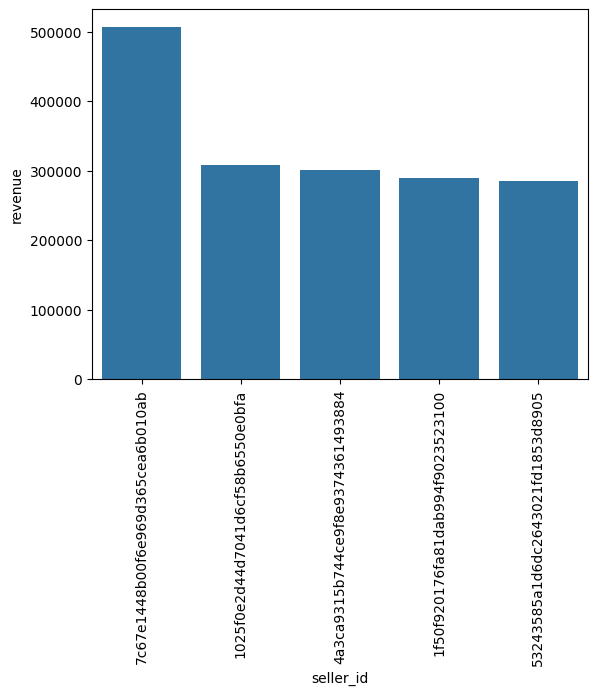

In [18]:
query = """select * , dense_rank() over(order by revenue desc) as rn  from 
(select order_items.seller_id,round(sum(payments.payment_value),2)revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id)  as a
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x = "seller_id" , y = "revenue" ,data = df)
plt.xticks(rotation = 90)
plt.show()

##ADVANCED QUERIES

**11.Calculate the moving average of order values for each customer over their order history.**

In [19]:
query = """select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id  order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a
"""
cur.execute(query)

data = cur.fetchall()
df =pd.DataFrame(data,columns = ["customer_id","order_purchase_timestamp","payment","mov_avg"])
df


,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


**12.Calculate the cumulative sales per month for each year**

In [21]:
query = """select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales  from
(select year(orders.order_purchase_timestamp)as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment  from orders join payments
on orders.order_id = payments.order_id
group by years,months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","months","payments","cumulative_sales"])
df

,years,months,payments,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


**13.Calculate the year-over-year growth rate of total sales**

In [22]:
query ="""with a as(select year(orders.order_purchase_timestamp)as years,
round(sum(payments.payment_value),2) as payment  from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment ,1) over(order by years))*100 from a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns =["years","YOY % growth"])
df

,years,YOY % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


**14.Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.**

In [23]:
query = """with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp <
date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
 

"""
cur.execute(query)
data = cur.fetchall() # since none of our customers are repeated there is null value
data

[(None,)]

**15.Identify the top 3 customers who spent the most money in each year.**

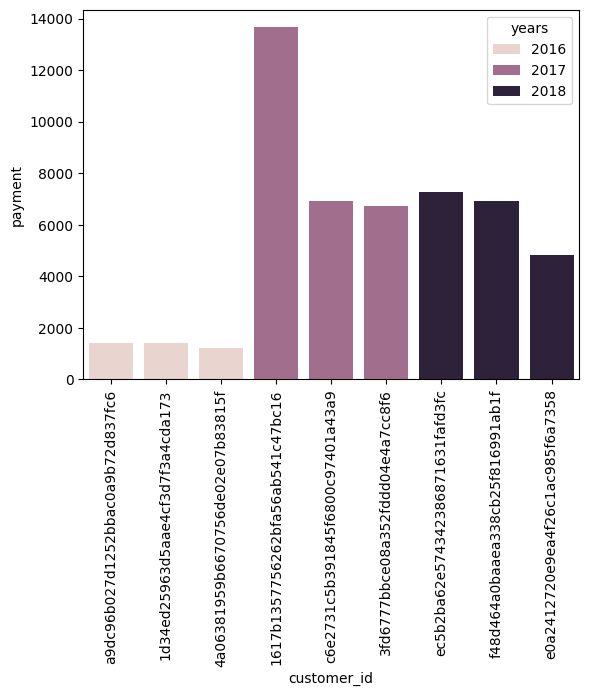

In [24]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp) ,
orders.customer_id)as a
where d_rank <= 3
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","customer_id","payment","d_rank"])
sns.barplot(x = "customer_id",y ="payment",data = df ,hue = "years")
plt.xticks(rotation = 90)
plt.show()

##THANKYOU